# Project 3: Panoramic Mosaicing

In [141]:
import numpy as np
from numpy.linalg import inv
import cv2 as cv
import random
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
rcParams = plt.rcParams
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

In [142]:
# Load all images
img1 = cv.resize(cv.imread('Images\campus1.jpg')[:,:,::-1], (600,600))
img2 = cv.resize(cv.imread('Images\campus2.jpg')[:,:,::-1], (600,600))
img3 = cv.resize(cv.imread('Images\campus3.jpg')[:,:,::-1], (600,600))

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img3_gray = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

# plt.subplot(131)
# plt.imshow(img1)
# just_title("Campus 1")

# plt.subplot(132)
# plt.imshow(img2)
# just_title("Campus 2")

# plt.subplot(133)
# plt.imshow(img3)
# just_title("Campus 3")

### Part A: Find Interest Points/Descriptors

In [143]:
def getDescriptors(img):
    copy_img = img.copy()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    cv.drawKeypoints(gray,kp,copy_img, (255,0,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return kp, des, copy_img

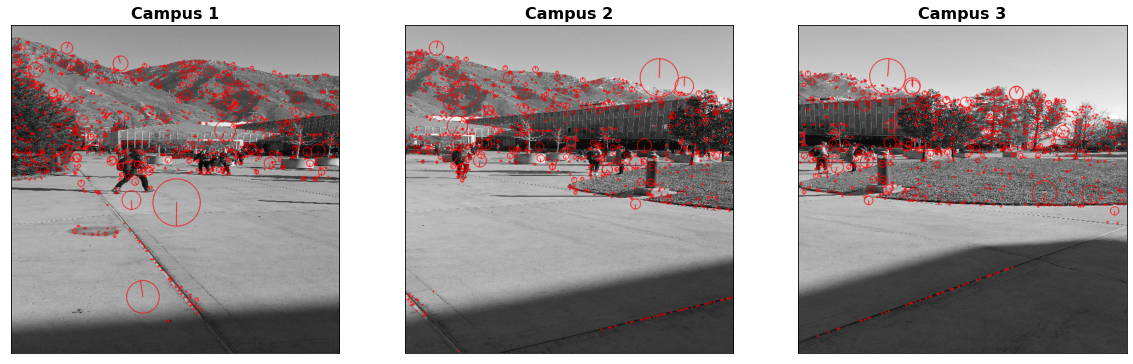

In [144]:
kp1, des1, img1_descriptors = getDescriptors(img1)
kp2, des2, img2_descriptors = getDescriptors(img2)
kp3, des3, img3_descriptors = getDescriptors(img3)


# Show an example output here
plt.subplot(131)
plt.imshow(img1_descriptors)
just_title("Campus 1")

plt.subplot(132)
plt.imshow(img2_descriptors)
just_title("Campus 2")

plt.subplot(133)
plt.imshow(img3_descriptors)
just_title("Campus 3")

### Part B: Matching Features

In [145]:
def BF_matcher(des_a, des_b, kp_a, kp_b, img_a, img_b):
    bf = cv.BFMatcher()

    matches = bf.knnMatch(des_a, des_b, k=2)

    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Apply ratio test
    good = [m for m,n in matches if m.distance < 0.75*n.distance]

    img_result = cv.drawMatches(img_a,kp_a,img_b,kp_b,good,
                                None,**draw_params)
    return img_result, good

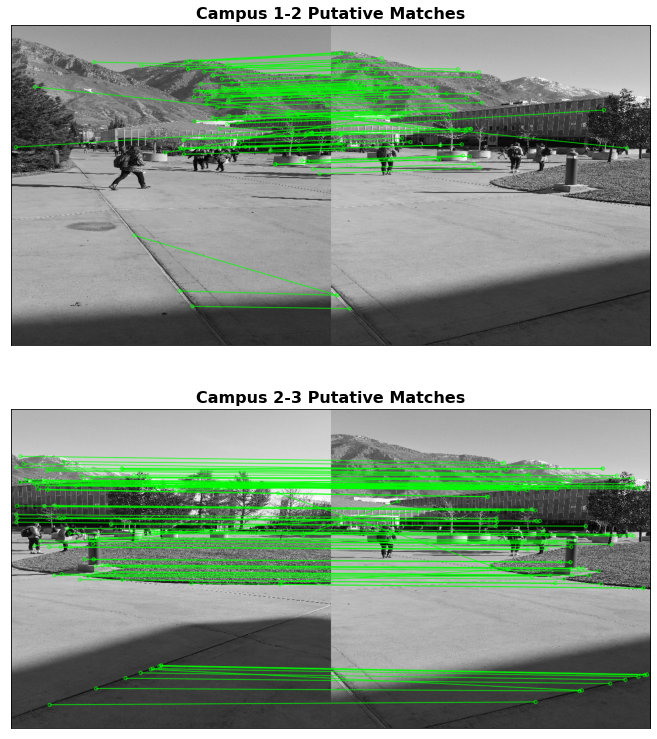

In [146]:
img_1_2_matches, matches12 = BF_matcher(des1, des2, kp1, kp2, img1_gray, img2_gray)
img_3_2_matches, matches32 = BF_matcher(des3, des2, kp3, kp2, img3_gray, img2_gray)

plt.subplot(311)
plt.imshow(img_1_2_matches)
just_title("Campus 1-2 Putative Matches")

plt.subplot(312)
plt.imshow(img_3_2_matches)
just_title("Campus 2-3 Putative Matches")

### Part C: Estimating Pairwise Homographies using RANSAC

In [182]:
# This function will find the homography of 4 given points
def find_homography(pt1, pt2, pt3, pt4, pt1_, pt2_, pt3_, pt4_):
    A = np.array([[pt1[0], pt1[1], 1, 0, 0, 0, -pt1_[0]*pt1[0], -pt1_[0]*pt1[1]], 
                 [0, 0, 0, pt1[0], pt1[1], 1, -pt1_[1]*pt1[0], -pt1_[1]*pt1[1]], 
    
                 [pt2[0], pt2[1], 1, 0, 0, 0, -pt2_[0]*pt2[0], -pt2_[0]*pt2[1]], 
                 [0, 0, 0, pt2[0], pt2[1], 1, -pt2_[1]*pt2[0], -pt2_[1]*pt2[1]],

                 [pt3[0], pt3[1], 1, 0, 0, 0, -pt3_[0]*pt3[0], -pt3_[0]*pt3[1]], 
                 [0, 0, 0, pt3[0], pt3[1], 1, -pt3_[1]*pt3[0], -pt3_[1]*pt3[1]],        

                 [pt4[0], pt4[1], 1, 0, 0, 0, -pt4_[0]*pt4[0], -pt4_[0]*pt4[1]], 
                 [0, 0, 0, pt4[0], pt4[1], 1, -pt4_[1]*pt4[0], -pt4_[1]*pt4[1]]])

    T = np.array([[pt1_[0]], [pt1_[1]], [pt2_[0]], [pt2_[1]], [pt3_[0]], [pt3_[1]], [pt4_[0]], [pt4_[1]]])

    return np.linalg.solve(A, T)

def find_inliers(kp_a, kp_b, matches, homography):
    H = np.resize(homography,(3,3))
    H[2,2] = 1
    consesus_set = 0

    for match in matches:
        new_point = H @ np.array([kp_a[match.queryIdx].pt[0], kp_a[match.queryIdx].pt[1], 1])
        base_point = np.array([kp_b[match.trainIdx].pt[0], kp_b[match.trainIdx].pt[1], 1])
        # print(np.linalg.norm(base_point - new_point))
        if (np.linalg.norm(base_point - new_point)) < 40:
            consesus_set += 1
    return consesus_set

def RANSAC(kp_a, kp_b, matches):
    for a in range(200):
        max_inliers = 0
        best_model = None
        
        # for the matches between img1 (source) and img2 (BASE)
        indices = [random.randrange(len(matches)) for num in range(4)]         # get 4 random indicies from the matches
        s = [kp_a[matches[i].queryIdx].pt for i in indices]
        base = [kp_b[matches[i].trainIdx].pt for i in indices]
        
        try:
            homography = find_homography(s[0], s[1], s[2], s[3], base[0], base[1], base[2], base[3])
            
        except:
            continue
        
        temp_num = find_inliers(kp_a, kp_b, matches, homography)

        if temp_num > max_inliers:
            max_inliers = temp_num
            best_model = homography

    best_model = np.resize(best_model,(3,3))
    best_model[2,2] = 1
    return best_model.astype(np.float32)

def get_corners(img):
    w,h = img.shape
    return np.array([[0,0], [w-1,0], [0,h-1], [w-1,h-1]], dtype=np.float32).reshape(-1,1,2)

def get_color_corners(img):
    w,h,c = img.shape
    return np.array([[0,0], [w-1,0], [0,h-1], [w-1,h-1]], dtype=np.float32).reshape(-1,1,2)

def get_warped_image(input_image, base_image, H):
    input_corners = get_corners(input_image)
    base_corners = get_corners(base_image)

    new_input_corners = cv.perspectiveTransform(input_corners, H)
    
    x0, y0, w0, h0 = cv.boundingRect(new_input_corners)
    x1, y1, w1, h1 = cv.boundingRect(base_corners)

    min_x = min(x0, x1, x0+w0, x1+w1)
    min_y = min(y0, y1, y0+h0, y1+h1)
    max_x = max(x0, x1, x0+w0, x1+w1)
    max_y = max(y0, y1, y0+h0, y1+h1)
    new_w = max_x - min_x
    new_h = max_y - min_y

    T = np.array([[1, 0, max(-min_x, 0)], [0, 1, max(-min_y, 0)], [0, 0, 1]], dtype=np.float32)

    input_warped = cv.warpPerspective(input_image, T @ H, (new_w, new_h))
    base_warped = cv.warpPerspective(base_image, T, (new_w, new_h))

    return input_warped, base_warped

def final_warp(input_left, input_right, base_image, HL, HR):
    input_left_corners = get_color_corners(input_left)
    input_right_corners = get_color_corners(input_right)
    base_corners = get_color_corners(base_image)

    new_inputleft_corners = cv.perspectiveTransform(input_left_corners, HL)
    new_inputright_corners = cv.perspectiveTransform(input_right_corners, HR)

    x0, y0, w0, h0 = cv.boundingRect(new_inputleft_corners)
    x1, y1, w1, h1 = cv.boundingRect(base_corners)
    x2, y2, w2, h2 = cv.boundingRect(new_inputright_corners)

    min_x = min(x0, x1, x2, x0+w0, x1+w1, x2+w2)
    min_y = min(y0, y1, y2, y0+h0, y1+h1, y2+h2)
    max_x = max(x0, x1, x2, x0+w0, x1+w1, x2+w2)
    max_y = max(y0, y1, y2, y0+h0, y1+h1, y2+h2)
    new_w = max_x - min_x
    new_h = max_y - min_y

    T = np.array([[1, 0, max(-min_x, 0)], [0, 1, max(-min_y, 0)], [0, 0, 1]], dtype=np.float32)

    left_warped = cv.warpPerspective(input_left, T @ HL, (new_w, new_h))
    right_warped = cv.warpPerspective(input_right, T @ HR, (new_w, new_h))
    base_warped = cv.warpPerspective(base_image, T, (new_w, new_h))

    return left_warped, right_warped, base_warped

In [183]:
homography12 = RANSAC(kp1, kp2, matches12)

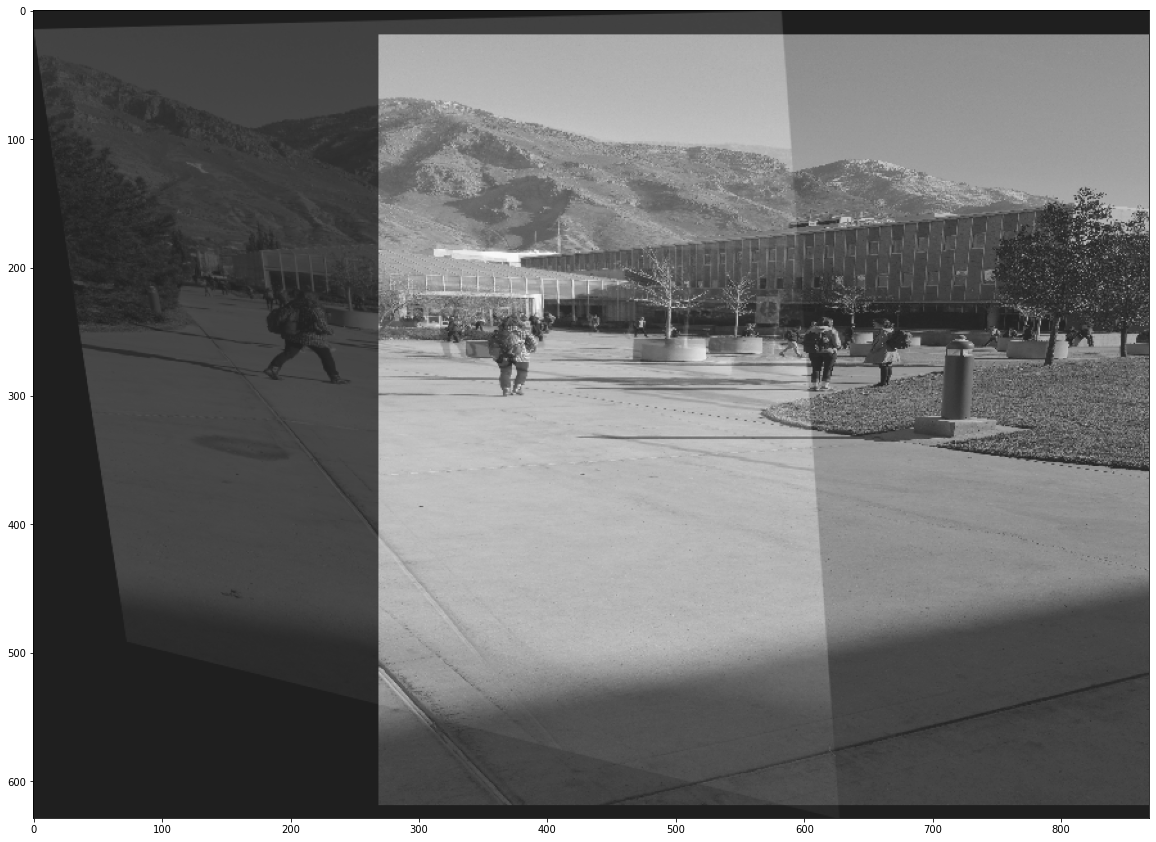

In [192]:
left_to_base, base_left = get_warped_image(img1_gray, img2_gray, homography12)
plt.figure()
plt.imshow(left_to_base, alpha=0.65, cmap='gray')
plt.imshow(base_left, alpha=0.65, cmap='gray')

In [177]:
homography32 = RANSAC(kp3, kp2, matches32)

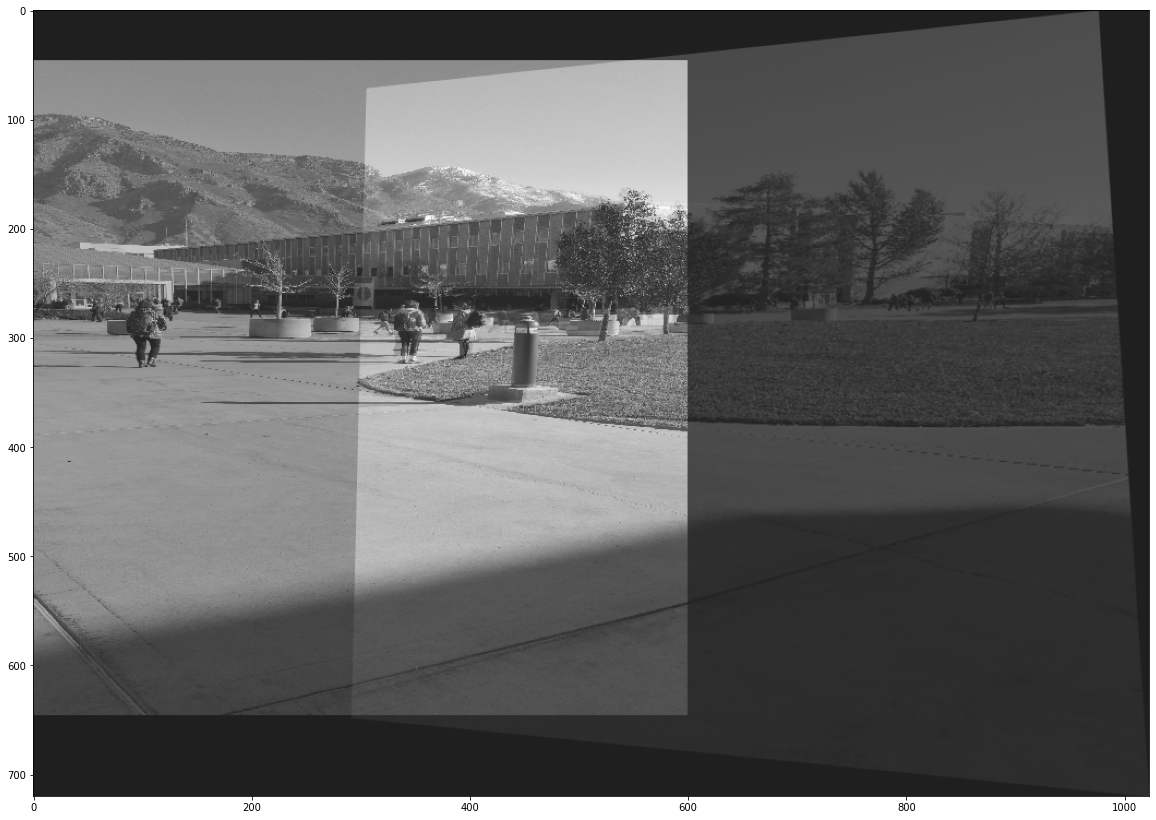

In [178]:
right_to_base, base_right = get_warped_image(img3_gray, img2_gray, homography32)
plt.figure()
plt.imshow(right_to_base, alpha=0.65, cmap='gray')
plt.imshow(base_right, alpha=0.65, cmap='gray')

### Part D: Creating the Mosaic

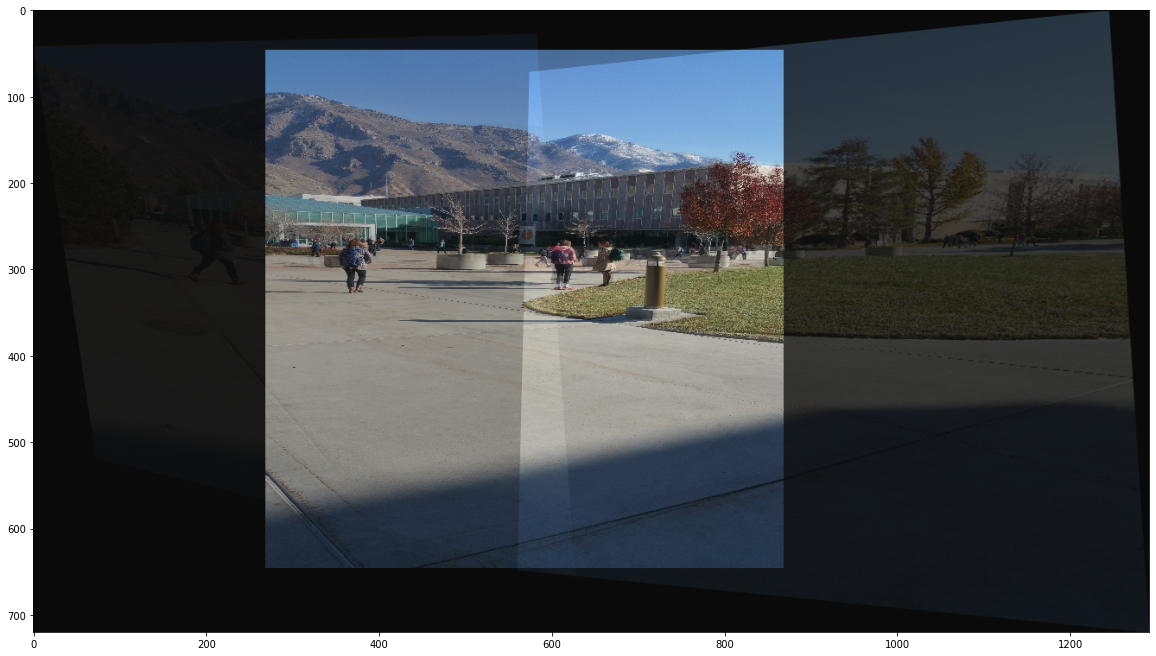

In [194]:
left_final, right_final, final_base = final_warp(img1, img3, img2, homography12, homography32)

plt.figure()
plt.imshow(left_final, alpha=0.65, cmap='gray')
plt.imshow(right_final, alpha=0.65, cmap='gray')
plt.imshow(final_base, alpha=0.65, cmap='gray')

### Final Results and Improvements

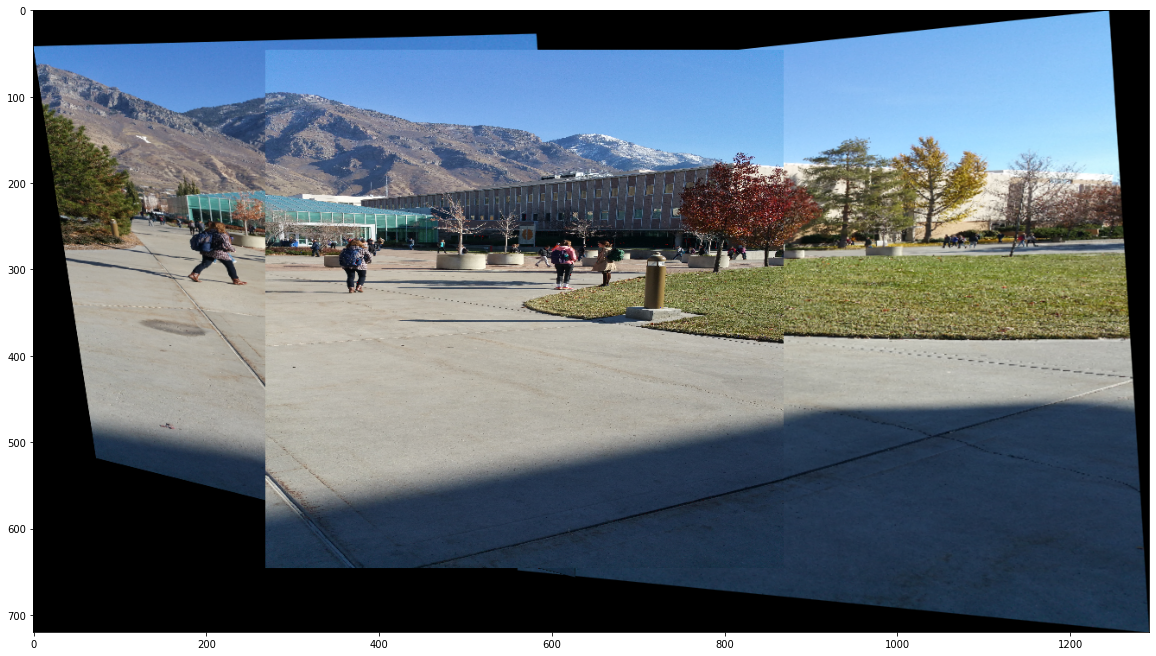

In [206]:
final_image = final_base.copy()

final_image = np.where(final_image != 0, final_image, left_final)
final_image = np.where(final_image != 0, final_image, right_final)


plt.figure()
plt.imshow(final_image)